In [142]:
import pandas as pd
dataset = pd.read_csv("/content/housing.csv")
dataset = dataset.dropna()
dataset.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fef8199c470>,
      dtype=object)

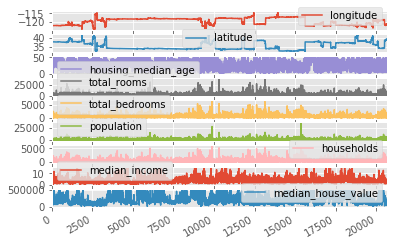

In [143]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')
dataset.plot(subplots=True)


In [144]:
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [145]:
Y = dataset['median_house_value']
X = dataset.loc[:,'longitude':'median_income']

print(X.shape)
print(Y.shape)

(20433, 8)
(20433,)


In [146]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.3, random_state=2003)

x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

print("There are " + str(x_train.size) + " training entries and "+  str(x_test.size) + " testing entries ")

There are 114424 training entries and 49040 testing entries 


In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs

    self.input_layer = Conv1d(inputs, batch_size, 1)
    self.max_pooling_layer = MaxPool1d(1)
    self.conv_layer = Conv1d(batch_size, 128, 1)
    self.flatten_layer = Flatten()
    self.linear_layer = Linear(128, 64)
    self.output_layer = Linear(64, outputs)

  def feed(self, input):

    input = input.reshape((self.batch_size, self.inputs,1))

    output = relu(self.input_layer(input))
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer(output))
    output = self.flatten_layer(output)
    output = self.linear_layer(output)
    output = self.output_layer(output)
    return output


In [149]:
from torch.optim import SGD
from torch.nn import L1Loss

!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score
from ignite.metrics import MeanSquaredError as mse

In [150]:
batch_size = 417
model = CnnRegressor(batch_size, X.shape[1], 1)
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 417, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(417, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model, dataset, train = False, optimizer = None):

  performance = L1Loss()
  score_metric = R2Score()
  mse_metric = mse()
  avg_loss = 0
  avg_score = 0
  avg_mse = 0
  count = 0

  for input, output in iter(dataset):

    predections = model.feed(input)
    loss = performance(predections, output)
    score_metric.update([predections, output])
    score = score_metric.compute()
    mse_metric.update([predections, output])
    scoretemp = mse_metric.compute()
    
    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    avg_loss += loss.item()
    avg_score += score
    avg_mse += scoretemp
    count += 1
    
  return avg_loss / count, avg_score / count, avg_mse / count

In [152]:
import time 
epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-3)
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor,batch_size, shuffle=True, drop_last=True)

t1 = time.time()

for epoch in range(epochs):
  avg_loss, avg_r2_score, avg_mse_score = model_loss(model, loader, train=True, optimizer=optimizer)



  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score)+ "\n\tMSEScore = " + str(avg_mse_score))

t2 = time.time()

Epoch 1:
	Loss = 159540.09053308822
	R^2 Score = -2.7154299256603873
	MSEScore = 49719358603.06885
Epoch 2:
	Loss = 116118.47104779411
	R^2 Score = -1.0125804005352284
	MSEScore = 26543683053.95481
Epoch 3:
	Loss = 110390.33340992648
	R^2 Score = -0.8938397112403005
	MSEScore = 25380726963.76972
Epoch 4:
	Loss = 99498.95680147059
	R^2 Score = -0.641471027701081
	MSEScore = 21631845885.712852
Epoch 5:
	Loss = 84431.68841911765
	R^2 Score = -0.05625612493431221
	MSEScore = 14180992579.261438
Epoch 6:
	Loss = 79504.28170955883
	R^2 Score = 0.16908219578024355
	MSEScore = 11003107495.74086
Epoch 7:
	Loss = 78088.2442555147
	R^2 Score = 0.2164704715354216
	MSEScore = 10336214774.336113
Epoch 8:
	Loss = 77585.89476102941
	R^2 Score = 0.23463454045686427
	MSEScore = 10314127583.802359
Epoch 9:
	Loss = 77236.54641544117
	R^2 Score = 0.20274780279466734
	MSEScore = 10242288724.033108
Epoch 10:
	Loss = 75290.04273897059
	R^2 Score = 0.26594749539686297
	MSEScore = 9763654608.200815
Epoch 11:
	Lo

In [153]:
print("time for running all epochs is " + str(t2-t1))

time for running all epochs is 131.06779742240906


In [154]:
filepath = "/content/1108021_1dconv_reg.pth"
torch.save(model,filepath)
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor,batch_size, shuffle=True, drop_last=True)
avg_loss, avg_r2_score,avg_mse_score = model_loss(model, loader)

print("Loss = " + str(avg_loss) + "\nR^2 Score = " + str(avg_r2_score)+ "\nMSE SCore = " + str(avg_mse_score))

Loss = 47325.952845982145
R^2 Score = 0.6724208988528065
MSE SCore = 4403922751.470468


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
